In [3]:
# Imports
import csv
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn import linear_model

In [4]:
path = 'datasets/airports.csv'
reader = csv.reader(open(path, 'rt'), delimiter=',')
airports = defaultdict(str)
header = next(reader)
for line in reader:
    d = dict(zip(header, line))
    if d['IATA_CODE'].isdigit(): continue
    airports[d['IATA_CODE']] = d['STATE']

In [5]:
# Read dataset
path = 'datasets/flights.csv'
reader = csv.reader(open(path, 'rt'), delimiter=',')
dataset = []
header = next(reader)
to_remove_fields = ['YEAR', 'TAXI_OUT', 'TAIL_NUMBER', 'TAXI_OUT', 'WHEELS_OFF', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 
                    'DIVERTED','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY']
for line in reader:
    d = dict(zip(header, line))
    if d['ORIGIN_AIRPORT'].isdigit() or d['DESTINATION_AIRPORT'].isdigit(): continue
    if airports[d['ORIGIN_AIRPORT']] != 'CA' or airports[d['DESTINATION_AIRPORT']] != 'CA': continue
    for field in to_remove_fields:
        d.pop(field, None)
    dataset.append(d)

In [47]:
# 5819079, 5332914, 208859
len(dataset), dataset[0]

(208859,
 {'MONTH': '1',
  'DAY': '1',
  'DAY_OF_WEEK': '4',
  'AIRLINE': 'OO',
  'FLIGHT_NUMBER': '5467',
  'ORIGIN_AIRPORT': 'ONT',
  'DESTINATION_AIRPORT': 'SFO',
  'SCHEDULED_DEPARTURE': '0500',
  'DEPARTURE_TIME': '0513',
  'DEPARTURE_DELAY': '13',
  'SCHEDULED_TIME': '89',
  'ELAPSED_TIME': '85',
  'DISTANCE': '363',
  'SCHEDULED_ARRIVAL': '0629',
  'ARRIVAL_TIME': '0638',
  'ARRIVAL_DELAY': '9',
  'CANCELLED': '0',
  'CANCELLATION_REASON': '',
  'WEATHER_DELAY': '',
  'PREV_FLIGHT_DELAY': 0})

# Exploration

## Airport Locations

In [24]:
airport_count = defaultdict(int)
for d in dataset:
    airport_count[d['ORIGIN_AIRPORT']] += 1

In [25]:
airport_count

defaultdict(int,
            {'ANC': 16005,
             'LAX': 194673,
             'SFO': 148008,
             'SEA': 110899,
             'LAS': 133181,
             'DEN': 196055,
             'SLC': 97210,
             'PDX': 47085,
             'FAI': 2183,
             'MSP': 112117,
             'PHX': 146815,
             'SJU': 24656,
             'PBG': 281,
             'IAG': 322,
             'PSE': 749,
             'BQN': 1343,
             'ORD': 285884,
             'GEG': 9505,
             'HNL': 43172,
             'ONT': 17978,
             'MCO': 110982,
             'BOS': 107847,
             'HIB': 898,
             'ABR': 671,
             'MAF': 7527,
             'DFW': 239551,
             'MKE': 29825,
             'IAH': 146622,
             'BNA': 47580,
             'BRO': 2362,
             'VPS': 4868,
             'BOI': 11655,
             'BJI': 667,
             'SGF': 6236,
             'PHL': 66021,
             'SBN': 4454,
             'RDD':

In [31]:
# Convert to time
for d in dataset:
    d['SCHEDULED_DEPARTURE'] = time.strptime(d['SCHEDULED_DEPARTURE'], "%H%M")
    d['DEPARTURE_TIME'] = time.strptime(d['DEPARTURE_TIME'], "%H%M")
    d['SCHEDULED_ARRIVAL'] = time.strptime(d['SCHEDULED_ARRIVAL'], "%H%M")
    d['ARRIVAL_TIME'] = time.strptime(d['ARRIVAL_TIME'], "%H%M")

KeyboardInterrupt: 

In [5]:
dataset[0]

{'YEAR': '2015',
 'MONTH': '1',
 'DAY': '1',
 'DAY_OF_WEEK': '4',
 'AIRLINE': 'AS',
 'FLIGHT_NUMBER': '98',
 'ORIGIN_AIRPORT': 'ANC',
 'DESTINATION_AIRPORT': 'SEA',
 'SCHEDULED_DEPARTURE': '0005',
 'DEPARTURE_TIME': '2354',
 'DEPARTURE_DELAY': '-11',
 'SCHEDULED_TIME': '205',
 'ELAPSED_TIME': '194',
 'DISTANCE': '1448',
 'SCHEDULED_ARRIVAL': '0430',
 'ARRIVAL_TIME': '0408',
 'ARRIVAL_DELAY': '-22',
 'CANCELLED': '0',
 'CANCELLATION_REASON': '',
 'WEATHER_DELAY': ''}

## Basic Statistics

### Num of Flights Per Airline Company

In [5]:
num_flights_per_airline = defaultdict(int)
for d in dataset:
    num_flights_per_airline[d['AIRLINE']] += 1

In [6]:
num_flights_per_airline

defaultdict(int,
            {'OO': 76153,
             'UA': 12776,
             'B6': 5322,
             'VX': 9997,
             'AA': 3898,
             'AS': 1249,
             'WN': 95632,
             'DL': 3632,
             'NK': 200})

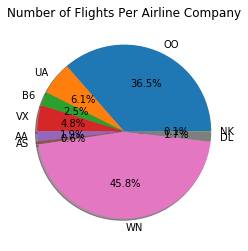

In [7]:
x_vals = []
y_vals = []
total_flights = sum(num_flights_per_airline.values())
for d in num_flights_per_airline:
    x_vals.append(d)
    y_vals.append(num_flights_per_airline[d]/total_flights)
plt.pie(y_vals, labels=x_vals, shadow=True, autopct='%1.1f%%')
# plt.axis('equal')
plt.title('Number of Flights Per Airline Company')
plt.show()

### Delays Distribution Per Airline

In [8]:
# Remove cancelled flights and get the mean delay time for each airline
delays_per_airline = defaultdict(list)
for d in dataset:
    if d['DEPARTURE_DELAY']:
        delays_per_airline[d['AIRLINE']].append(int(d['DEPARTURE_DELAY']))

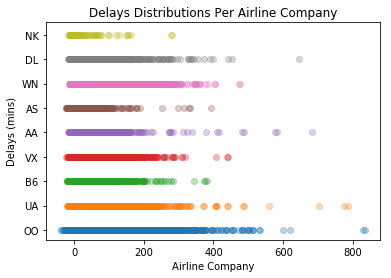

In [9]:
for d in delays_per_airline:
    y = delays_per_airline[d]
    plt.scatter(y, [d] * len(y), alpha=0.3)
plt.xlabel('Airline Company')
plt.ylabel('Delays (mins)')
plt.title('Delays Distributions Per Airline Company')
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)

### Delays Max, Min, Mean Per Airline

In [10]:
x_vals = []
y_min_delay = []
y_max_delay = []
y_mean_delay = []
for d in delays_per_airline:
    x_vals.append(d)
    y_min_delay.append(min(delays_per_airline[d]))
    y_max_delay.append(max(delays_per_airline[d]))
    y_mean_delay.append(sum(delays_per_airline[d]) / len(delays_per_airline[d]))

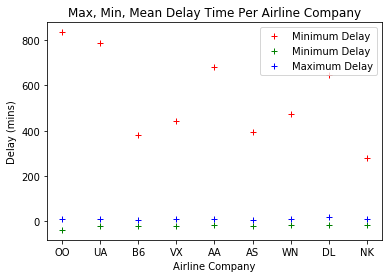

In [11]:
plt.plot(x_vals, y_max_delay, 'r+', label='Minimum Delay')
plt.plot(x_vals, y_min_delay, 'g+', label='Minimum Delay')
plt.plot(x_vals, y_mean_delay, 'b+', label='Maximum Delay')
plt.xlabel('Airline Company')
plt.ylabel('Delay (mins)')
plt.title('Max, Min, Mean Delay Time Per Airline Company')
plt.legend()
plt.show()

### Boxplot

In [12]:
x_vals = []
y_vals = []
for d in delays_per_airline:
    x_vals.append(d)
    y_vals.append(list(delays_per_airline[d]))

In [15]:
len(x_vals)

9

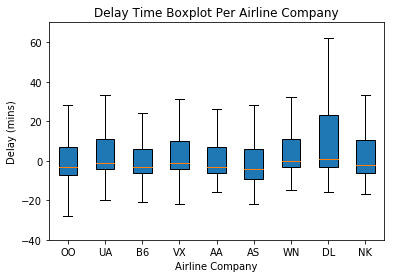

In [16]:
ind = np.arange(1, 10, 1)
plt.ylim(-40, 70)
plt.boxplot(y_vals, patch_artist=True, showfliers=False, labels=x_vals)
plt.xlabel('Airline Company')
plt.ylabel('Delay (mins)')
plt.title('Delay Time Boxplot Per Airline Company')
plt.xticks(ind, x_vals)
plt.show()

### Mean Delays Per Airline Company

In [17]:
mean_delay_per_airline = {}
for d in delays_per_airline:
    mean_delay_per_airline[d] = sum(delays_per_airline[d])/len(delays_per_airline[d])

In [18]:
mean_delay_per_airline

{'OO': 9.190560519466581,
 'UA': 12.297821969696969,
 'B6': 7.770090978013647,
 'VX': 10.650317252492698,
 'AA': 9.028674761043659,
 'AS': 7.157051282051282,
 'WN': 10.364267473550935,
 'DL': 19.5563868107509,
 'NK': 11.933673469387756}

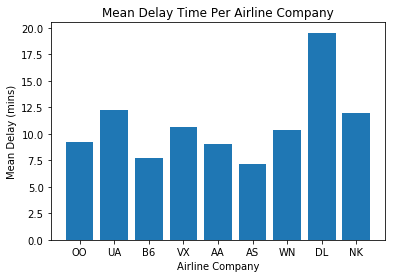

In [19]:
x_vals = []
y_vals = []
for d in mean_delay_per_airline:
    x_vals.append(d)
    y_vals.append(mean_delay_per_airline[d])
plt.bar(x_vals, y_vals)
plt.xlabel('Airline Company')
plt.ylabel('Mean Delay (mins)')
plt.title('Mean Delay Time Per Airline Company')
plt.show()

### Delays Count Categorized

In [20]:
len(ind), len(y_ontime)

NameError: name 'y_ontime' is not defined

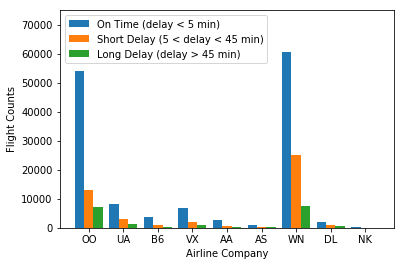

In [25]:
index = 1
width = 0.27
x_vals = []
y_ontime = []
y_short_delay = []
y_long_delay = []
for d in delays_per_airline:
    x_vals.append(d)
    y_ontime.append(0)
    y_short_delay.append(0)
    y_long_delay.append(0)
    for y in delays_per_airline[d]:
        if y < 5: y_ontime[index-1] += 1
        elif y < 45: y_short_delay[index-1] += 1
        else: y_long_delay[index-1] += 1
    index += 1
ind = np.arange(1, 10, 1)
plt.bar(ind-width, y_ontime, width, color='tab:blue', label='On Time (delay < 5 min)')
plt.bar(ind, y_short_delay, width, color='tab:orange', label='Short Delay (5 < delay < 45 min)')
plt.bar(ind+width, y_long_delay, width, color='tab:green', label='Long Delay (delay > 45 min)')
plt.xticks(ind, x_vals)
plt.ylim(0, 7.5e4)
plt.legend(loc='upper left')
plt.xlabel('Airline Company')
plt.ylabel('Flight Counts')
plt.show()

### Delays Per Airport

In [26]:
flights_per_airport = defaultdict(int)
for d in dataset:
    flights_per_airport[d['ORIGIN_AIRPORT']] += 1

In [27]:
### Only for delays > 5 mins
delays_per_airport = defaultdict(list)
for d in dataset:
    if d['DEPARTURE_DELAY'] and int(d['DEPARTURE_DELAY']) > 5:
        delays_per_airport[d['ORIGIN_AIRPORT']].append(d['DEPARTURE_DELAY'])

In [28]:
delays_per_airport

defaultdict(list,
            {'ONT': ['13',
              '18',
              '29',
              '9',
              '15',
              '45',
              '16',
              '49',
              '35',
              '48',
              '28',
              '11',
              '47',
              '21',
              '9',
              '19',
              '15',
              '19',
              '35',
              '103',
              '74',
              '42',
              '20',
              '50',
              '21',
              '18',
              '6',
              '12',
              '32',
              '19',
              '38',
              '64',
              '46',
              '27',
              '64',
              '73',
              '27',
              '30',
              '11',
              '12',
              '31',
              '7',
              '49',
              '246',
              '100',
              '34',
              '41',
              '24',
              '6

In [29]:
percentage_count_delayed_flights_per_airport = defaultdict(float)
for d in delays_per_airport:
    if flights_per_airport[d] == 0: continue
    percentage_count_delayed_flights_per_airport[d] = len(delays_per_airport[d])/flights_per_airport[d]

In [30]:
percentage_count_delayed_flights_per_airport

defaultdict(float,
            {'ONT': 0.30441599163835903,
             'CLD': 0.18252730109204368,
             'PSP': 0.2741823242867084,
             'SFO': 0.2744985399013835,
             'SNA': 0.3147400085947572,
             'LAX': 0.325956234740935,
             'SMF': 0.2932442025556081,
             'OAK': 0.3183288128520759,
             'SAN': 0.30814751692467923,
             'SJC': 0.31013801109248035,
             'SBP': 0.2388245033112583,
             'SBA': 0.24515040764689344,
             'BUR': 0.23364681295715778,
             'SMX': 0.19427710843373494,
             'FAT': 0.288961038961039,
             'ACV': 0.25984848484848483,
             'LGB': 0.27669172932330827,
             'RDD': 0.2077028885832187,
             'MMH': 0.2808219178082192,
             'MRY': 0.2041773231031543,
             'CEC': 0.29473684210526313,
             'BFL': 0.25606060606060604})

AttributeError: 'AxesSubplot' object has no attribute 'show'

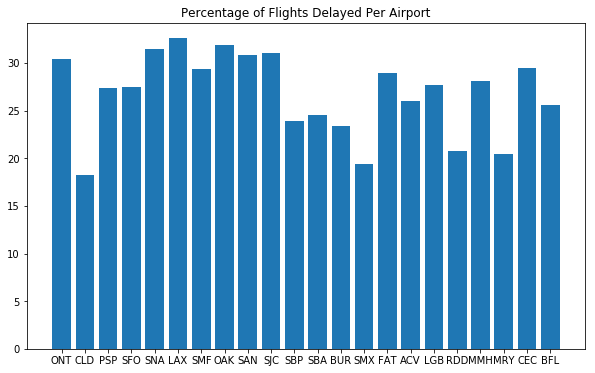

In [31]:
x_vals = []
y_vals = []
for d in percentage_count_delayed_flights_per_airport:
    if d.isdigit(): continue
    x_vals.append(d)
    y_vals.append(percentage_count_delayed_flights_per_airport[d]*100)
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x_vals, y_vals)
plt.title('Percentage of Flights Delayed Per Airport')
ax.show()

In [32]:
len(x_vals)

22

## Prediction Task

#### Data Setup


In [6]:
delays_dataset = []
for d in dataset:
    if d['DEPARTURE_DELAY']: 
        delays_dataset.append(d)

In [7]:
# Add a new feature prev flight (same airline and same airport)
prev_flight_delay = {}
for i in range(len(delays_dataset)):
    d = delays_dataset[i]
    tup = (d['AIRLINE'], d['ORIGIN_AIRPORT'])
    if tup not in prev_flight_delay:
        prev_flight_delay[tup] = 0
    delays_dataset[i]['PREV_FLIGHT_DELAY'] = prev_flight_delay[tup]
    prev_flight_delay[tup] = int(d['DEPARTURE_DELAY'])
del prev_flight_delay

In [8]:
# Function to split data 90 - 10
def split_data(data):
    N = len(data)
    trainset = []
    testset = []
    for i in range(len(data)):
        if i % 10 == 0:
            testset.append(data[i])
        else:
            trainset.append(data[i])
    return trainset, testset

In [9]:
train, test = split_data(delays_dataset)
train, valid = split_data(train)
N = len(delays_dataset)
Ntrain = len(train)
Nvalid = len(valid)
Ntest = len(test)
N, Ntrain, Nvalid, Ntest, Ntrain+Nvalid+Ntest

(204537, 165674, 18409, 20454, 204537)

In [10]:
airline_set = set()
airport_set = set()
for d in delays_dataset:
    airline_set.add(d['AIRLINE'])
    airport_set.add(d['ORIGIN_AIRPORT'])
airline_list = list(airline_set)
airline_list.sort()
airport_list = list(airport_set)
airport_list.sort()
airline_encoding = {}
airport_encoding = {}
for i in range(len(airline_list)):
    airline_encoding[airline_list[i]] = i
for i in range(len(airport_list)):
    airport_encoding[airport_list[i]] = i
del airline_set, airline_list
del airport_set, airport_list

In [11]:
# del dataset

In [12]:
airline_encoding, airport_encoding

({'AA': 0,
  'AS': 1,
  'B6': 2,
  'DL': 3,
  'NK': 4,
  'OO': 5,
  'UA': 6,
  'VX': 7,
  'WN': 8},
 {'ACV': 0,
  'BFL': 1,
  'BUR': 2,
  'CEC': 3,
  'CLD': 4,
  'FAT': 5,
  'LAX': 6,
  'LGB': 7,
  'MMH': 8,
  'MRY': 9,
  'OAK': 10,
  'ONT': 11,
  'PSP': 12,
  'RDD': 13,
  'SAN': 14,
  'SBA': 15,
  'SBP': 16,
  'SFO': 17,
  'SJC': 18,
  'SMF': 19,
  'SMX': 20,
  'SNA': 21})

In [13]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences)/len(differences)

In [14]:
def feature_baseline_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    feat = [1] + airline_feat + airport_feat
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    return feat

In [15]:
def feature_baseline(datum):
    feat = [1, datum['AIRLINE'], datum['ORIGIN_AIRPORT']]
    return feat

In [16]:
# Training data features
Xtrain = [feature_baseline_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_baseline_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_baseline_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [44]:
Xtest[0], ytest[0], Xtrain[0], ytrain[0], train[0]

([1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 13,
 [1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0],
 5,
 {'MONTH': '1',
  'DAY': '1',
  'DAY_OF_WEEK': '4',
  'AIRLINE': 'UA',
  'FLIGHT_NUMBER': '1224',
  'ORIGIN_AIRPORT': 'SFO',
  'DESTINATION_AIRPORT': 'LAX',
  'SCHEDULED_DEPARTURE': '0600',
  'DEPARTURE_TIME': '0605',
  'DEPARTURE_DELAY': '5',
  'SCHEDULED_TIME': '88',
  'ELAPSED_TIME': '72',
  'DISTANCE': '337',
  'SCHEDULED_ARRIVAL': '0728',
  'ARRIVAL_TIME': '0717',
  'ARRIVAL_DELAY': '-11',
  'CANCELLED': '0',
  'CANCELLATION_REASON': '',
  'WEATHER_DELAY': '',
  'PREV_FLIGHT_DELAY': 0})

In [17]:
theta, residual, rank, s = np.linalg.lstsq(Xtrain, ytrain, rcond=None)
print("Trained")
predictions_train = np.matmul(Xtrain, theta)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = np.matmul(Xtest, theta)
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

Trained
MSE on training set: 1051.245050529889
MSE on test set: 1016.0178192842035


In [18]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
print("Trained")
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

Trained
MSE on training set: 1051.2543948138168
MSE on test set: 1015.9799105859728


In [19]:
def feature(datum):
    feat = [1, datum['AIRLINE'], datum['ORIGIN_AIRPORT'], datum['PREV_FLIGHT_DELAY']]
    return feat

In [20]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    feat = [1] + airline_feat + airport_feat + month_feat + [int(datum['PREV_FLIGHT_DELAY'])]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    return feat

In [21]:
# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [109]:
Xtrain[0], ytrain[0], train[0]

([1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 5,
 {'MONTH': '1',
  'DAY': '1',
  'DAY_OF_WEEK': '4',
  'AIRLINE': 'UA',
  'FLIGHT_NUMBER': '1224',
  'ORIGIN_AIRPORT': 'SFO',
  'DESTINATION_AIRPORT': 'LAX',
  'SCHEDULED_DEPARTURE': '0600',
  'DEPARTURE_TIME': '0605',
  'DEPARTURE_DELAY': '5',
  'SCHEDULED_TIME': '88',
  'ELAPSED_TIME': '72',
  'DISTANCE': '337',
  'SCHEDULED_ARRIVAL': '0728',
  'ARRIVAL_TIME': '0717',
  'ARRIVAL_DELAY': '-11',
  'CANCELLED': '0',
  'CANCELLATION_REASON': '',
  'WEATHER_DELAY': '',
  'PREV_FLIGHT_DELAY': 0})

In [22]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

MSE on training set: 1019.14435921868
MSE on test set: 987.2611475199088


### Predict Model 3

In [23]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + [int(datum['PREV_FLIGHT_DELAY'])]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    return feat

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [24]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

MSE on training set: 1008.7744158796227
MSE on test set: 977.7327252735631


### Predict Model 4

In [25]:
import json
with open('datasets/Latent_3_train_27300.txt', "r") as f:
    obj = json.loads(f.readline())
    airports = obj['airports']
    airlines = obj['airlines']
    airportGamma = obj['airportGamma']
    airlineGamma = obj['airlineGamma']

In [32]:
airportGamma

{'CEC': [0.21862215967100684, -0.020239618983690776, 0.577015450641341],
 'BFL': [-0.6359183177863826, -0.06386250278928365, -0.8201678658373637],
 'RDD': [-1.162976542263677, -0.38226210904381663, -0.6356518700410257],
 'SMF': [0.0847912765741204, 0.2016256158973445, 0.7226511046989798],
 'SMX': [-0.6748956729433501, 0.20522689854120127, -0.4234683490525503],
 'CLD': [-0.4782927108496622, -0.15890521992002374, -0.7341758429060787],
 'SJC': [0.08537599932131593, 1.2355037591576494, 0.3168502588989911],
 'LGB': [0.96886596410043, 0.3293704552590726, 0.8206125037567444],
 'ACV': [0.30274016477007093, -0.053114570387953454, -0.18213906965097132],
 'BUR': [-0.0868381866010161, 0.9747404218891719, 0.05656436558894726],
 'LAX': [-0.9452587493980388, -1.8294874875211973, -0.6046241553898603],
 'SBP': [-0.7973149458676267, 0.17095090136029856, -0.38151782256547295],
 'FAT': [1.115444418406156, 0.4483054239055657, 0.766856429827529],
 'OAK': [1.4847032665475355, 0.32340511276064704, -0.29578822

In [26]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + [int(datum['PREV_FLIGHT_DELAY'])] + airportGamma[datum['ORIGIN_AIRPORT']] + airportGamma[datum['DESTINATION_AIRPORT']] + airlineGamma[datum['AIRLINE']]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    return feat

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [27]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

MSE on training set: 1008.7744190036423
MSE on test set: 977.7327765998243


### Predict Model 5

In [28]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    dep_time = [0]*4
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + dep_time + [int(datum['PREV_FLIGHT_DELAY'])] + airportGamma[datum['ORIGIN_AIRPORT']] + airportGamma[datum['DESTINATION_AIRPORT']] + airlineGamma[datum['AIRLINE']]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    ind_dep_time = 0
    if int(datum['DEPARTURE_TIME']) < 900:
        ind_dep_time = 0
    elif int(datum['DEPARTURE_TIME']) < 1100:
        ind_dep_time = 1
    elif int(datum['DEPARTURE_TIME']) < 2100:
        ind_dep_time = 2
    else:
        ind_dep_time = 3
    ind_dep_time = ind_dep_time + len(airport_encoding) + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    feat[ind_dep_time] = 1
    return feat

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [29]:
regressor = linear_model.LinearRegression()
regressor.fit(Xtrain, ytrain)
predictions_train = regressor.predict(Xtrain)
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(Xtest)
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

MSE on training set: 968.0160857242196
MSE on test set: 940.1131832220747


### Predict Average for Each Airline

In [30]:
train_delays_per_airline = defaultdict(list)
for d in train:
    train_delays_per_airline[d['AIRLINE']].append(int(d['DEPARTURE_DELAY']))

In [31]:
average_delays_per_airline = defaultdict(float)
for d in train_delays_per_airline:
    average_delays_per_airline[d] = sum(train_delays_per_airline[d])/len(train_delays_per_airline[d])

In [32]:
average_delays_per_airline

defaultdict(float,
            {'UA': 12.313213066796685,
             'B6': 7.686842720261743,
             'OO': 9.10770836093812,
             'VX': 10.548656047784968,
             'AS': 6.801548886737657,
             'WN': 10.353384454421445,
             'AA': 9.181327405525563,
             'DL': 19.65580589254766,
             'NK': 12.383116883116884})

In [33]:
ypred = []
for x in test:
    ypred.append(average_delays_per_airline[x['AIRLINE']])
test_accuracy = MSE(ypred, ytest)
print("MSE on test set: " + str(test_accuracy))

MSE on test set: 1016.4428926186471


In [67]:
test[0]['AIRLINE']

'OO'

### Predict Model 6 (xgboost)

In [41]:
def feature_onehot(datum):
    airline_feat = [0]*len(airline_encoding)
    airport_feat = [0]*len(airport_encoding)
    month_feat = [0]*12
    day_of_week_feat = [0]*7
    airport_dst_feat = [0]*len(airport_encoding)
    dep_time = [0]*4
    feat = [1] + airline_feat + airport_feat + month_feat + day_of_week_feat + airport_dst_feat + dep_time + [int(datum['PREV_FLIGHT_DELAY'])] + airportGamma[datum['ORIGIN_AIRPORT']] + airportGamma[datum['DESTINATION_AIRPORT']] + airlineGamma[datum['AIRLINE']]
    ind_airline = airline_encoding[datum['AIRLINE']] + 1
    ind_airport = airport_encoding[datum['ORIGIN_AIRPORT']] + len(airline_encoding) + 1
    ind_month = int(datum['MONTH']) + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_day_of_week = int(datum['DAY_OF_WEEK']) + 12 + len(airport_encoding) + len(airline_encoding) + 1 - 1
    ind_airport_dst = airport_encoding[datum['DESTINATION_AIRPORT']] + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    ind_dep_time = 0
    if int(datum['DEPARTURE_TIME']) < 900:
        ind_dep_time = 0
    elif int(datum['DEPARTURE_TIME']) < 1100:
        ind_dep_time = 1
    elif int(datum['DEPARTURE_TIME']) < 2100:
        ind_dep_time = 2
    else:
        ind_dep_time = 3
    ind_dep_time = ind_dep_time + len(airport_encoding) + 7 + 12 + len(airport_encoding) + len(airline_encoding) + 1
    feat[ind_airline] = 1
    feat[ind_airport] = 1
    feat[ind_month] = 1
    feat[ind_day_of_week] = 1
    feat[ind_airport_dst] = 1
    feat[ind_dep_time] = 1
    return feat

# Training data features
Xtrain = [feature_onehot(d) for d in train]
ytrain = [int(d['DEPARTURE_DELAY']) for d in train]
print("training set")

# Valid data features
Xvalid = [feature_onehot(d) for d in valid]
yvalid = [int(d['DEPARTURE_DELAY']) for d in valid]
print("valid set")

# Test data features
Xtest = [feature_onehot(d) for d in test]
ytest = [int(d['DEPARTURE_DELAY']) for d in test]
print("test set")


training set
valid set
test set


In [42]:
import xgboost
regressor = xgboost.XGBRegressor()
regressor.fit(np.matrix(Xtrain), np.array(ytrain))
predictions_train = regressor.predict(np.matrix(Xtrain))
train_accuracy = MSE(predictions_train, ytrain)
predictions_test = regressor.predict(np.matrix(Xtest))
test_accuracy = MSE(predictions_test, ytest)
print("MSE on training set: " + str(train_accuracy))
print("MSE on test set: " + str(test_accuracy))

[23:17:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE on training set: 941.9430187708502
MSE on test set: 919.8395575638817


### Compare Models

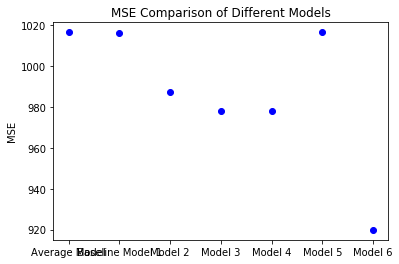

In [43]:
x_vals = ['Average Model', 'Baseline Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
y_vals = [1016.4428926186471, 1016.0188813832914, 987.2611475199087, 977.7327252735631, 977.7327765998243, 1016.4428926186471, 919.8395575638817]
plt.plot(x_vals, y_vals, 'bo')
plt.ylabel('MSE')
plt.title('MSE Comparison of Different Models')
plt.show()